# Invariants in RANS models


All $k$-$\varepsilon$ and EARS models try to model the Reynolds stress tensor, which we can write in anisotropic form:


$$ a_{ij} = \frac{\overline{u_i' u_j'} }{k} - \frac{2}{3}\delta_{ij} $$

*(the above is the notation of Taulbee (1992), Apsley (1998), Wallin (2000), Lazeroms (2013), Paul (2014) and Zeli (2020), while Pope (2000), Ali (2018) and Rey (2019) use $a_{ij} = \overline{u_i u_j} - \frac{2}{3} k \delta_{ij}$; beware, Møller (2021) uses a third definition!)*.

All people working with Lumley trinagles and barycentric map seem to use:

$$ b_{ij} = \frac{\overline{u_i' u_j'} }{2 k} - \frac{1}{3}\delta_{ij} $$

*(e.g. Pope (2000), Simonsen (2005), Ali (2018), Rey (2019), Stiperski (2021); beware, Møller (2021) calls it $a_{ij}$ and also Goderie (2020) uses an alternative definition...)*

## Properties of the Reynolds stress tensor

These just follow from the definition of $\overline{u_i' u_j'}$:
- $\overline{u_i' u_j'}$ is real (none of the components and be imaginary!)
- $\overline{u_i' u_j'}$ is symmetric

These are the so called "realizability" constraints of Schumann (1977):
- $0 \leq \overline{u_\alpha' u_\alpha'} \leq 2 k$
- $\left(\overline{u_\alpha' u_\beta'}\right)^2 \leq \overline{u_\alpha' u_\alpha'} \, \overline{u_\beta' u_\beta'} \leq k^2 $

We can confirm these properties numerically by looking at some PyWakeEllipSys results (note, not all turbulence models adhere to these constraints and Rethore (2009) showed that the regular $k$-$\varepsilon$-model is *not* realizable in the vicinity of the AD):

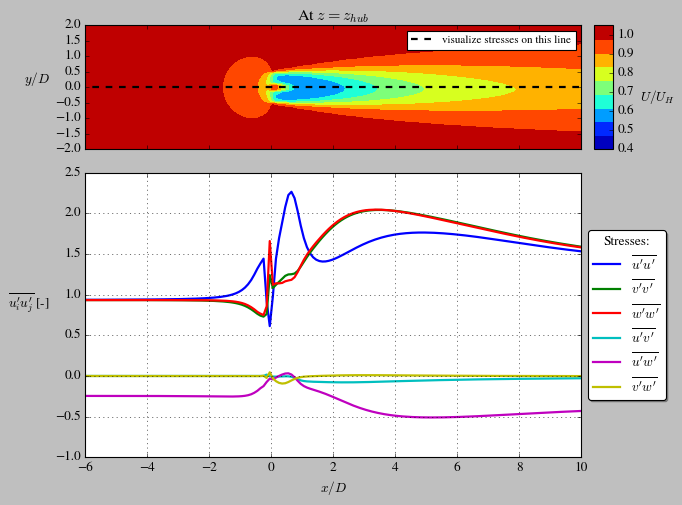

In [1]:
import numpy as np
import xarray
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm
from mchba.flowdata import calc_stresses


# PLOT STYLE ##################################
mpl.style.use('classic')
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams["legend.scatterpoints"] = 1
plt.rcParams["legend.numpoints"] = 1
plt.rcParams['grid.linestyle'] = ':'
mpl.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid']=True
yd = dict(rotation=0, ha='right')
plt.close('all')




# PARAMETERS ########################################
D = 126.0
zh = 90.0
UH = 8
x_ex = [-5*D, 1*D, 5*D]


## DATA
# Neutral k-eps-fP, U=8, TI=12, NREL5MW
filename = 'flowdata_invariants.nc'
data = xarray.open_dataset(filename)
x_off = 2.5*D  # Trasnlate everything 2.5D to the right to have AD at x=0
data = data.assign_coords(x=(data.x + x_off)) # Translate coordinates
stresses = calc_stresses(data)



# PLOT XY-plane #############################
#fig, ax = plt.subplots(1, 2, sharex='col', figsize=(12, 6),
#                       gridspec_kw={'width_ratios': (30, 1)})
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
plt.subplots_adjust(hspace=-0.2)
xyplane = data.interp(z=zh)
X, Y = np.meshgrid(xyplane.x, xyplane.y)
p = ax[0].contourf(X / D, Y / D, xyplane['U'].T / UH, np.linspace(0.4, 1.05, 10), cmap=cm.jet)
# Plot where budgets are extracted:
ax[0].plot([np.min(data['x']), np.max(data['x'])], [0, 0], 'k--', label='visualize stresses on this line')
#for i in range(len(x_ex)):
#    ax[0].plot([x_ex[i] / D], [0], 'ko', markersize=8, label='extract stress tensor for Jupyter notebook' if i == 1 else '')
ax[0].legend(fontsize=10)
ax[0].axis('scaled')
ax[0].set_xlim(left=-6, right=10)
ax[0].set_ylim(bottom=-2, top=2)
ax[1].set_xlabel('$x/D$')
ax[0].set_ylabel('$y/D$', yd)
ax[0].set_title('At $z = z_{hub}$')
ax[0].grid()
axpos = np.array(ax[0].get_position())  # [x0, y0; x1, y1], 0=lower left, 1=upper right
cbar = fig.add_axes([axpos[1,0]+0.02, axpos[0,1], 0.03, axpos[1,1]-axpos[0,1]]) # [minx, miny, dx, dy]
comcolRANS = plt.colorbar(p, cax=cbar, orientation='vertical', aspect=100)
comcolRANS.set_label('$U/U_H$', rotation=0, ha='left')
comcolRANS.set_ticks(np.arange(0.3, 1.05, 0.1))


# Plot stress lines
reynolds = ['uu', 'vv', 'ww', 'uv', 'uw', 'vw']
reynolds_str = ["$\overline{u'u'}$","$\overline{v'v'}$","$\overline{w'w'}$","$\overline{u'v'}$","$\overline{u'w'}$","$\overline{v'w'}$"]
stress_line = stresses.interp(y=0, z=zh)
for i in range(len(reynolds)):
    ax[1].plot(stress_line['x']/D,stress_line[reynolds[i]],label=reynolds_str[i])


# ylabel and legend
ax[1].set_ylabel(r"$\overline{u_i' u_j'}$ [-]",yd);
ax[1].legend(loc='center left',fontsize=12,bbox_to_anchor=(1.0, 0.5),
          ncol=1, fancybox=True, shadow=True,scatterpoints=1, handlelength=2,title='Stresses:')


The thing that makes $\overline{u_i' u_j'}$ a tensor and not just a matrix, is that each component has some sense of direction or coordinate-system $xyz$ associated with it. Let's say we wanted to express the Reynolds stresses in the $x'y'z'$-system instead (assume the new system is still right-handed and orthogonal), then it is actually pretty simple to transform the stresses to that system:

$$\overline{u_i' u_j'}_{x'y'z'} =  Q \overline{u_i' u_j'}_{xyz} Q^T$$ 

Here $Q$ is the *transformation* rotation matrix; the same as we use to rotate coordinatesystems with (NOT excactly the same we use rotate vectors with, see https://www.continuummechanics.org/coordxforms.html; it is simply the transpose of the regular rotation matrix!):

$$ Q_{2D} = \begin{bmatrix} 
       \mathrm{cos}(\theta) &  \mathrm{sin}(\theta) \\
       - \mathrm{sin}(\theta) & \mathrm{cos}(\theta) 
       \end{bmatrix}$$

$$ Q_{3D} = R^T, $$

where the 3D rotation matrix, $R$, is (https://en.wikipedia.org/wiki/Rotation_matrix):

<img src="rotation3D.png"/>

An easy interpretation of $Q$ in both 2D and 3D is that column 1 is the "x-axis" of the old system expressed in the new-system coordinates (i.e. can easily be understood, when one tries to transform the vector [1; 0] or [1; 0; 0], respectively).



In [2]:
## EXAMPLE OF TENSOR TRANSFORMATION IN 2D
uiuj = np.array([[2, 1], [1, 1]])
print('Original Reynolds tensor:')
print(uiuj)

def create_2Dtrans(theta):
    Q = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    return Q
theta90 = 90 * np.pi/180   # This means the old vv component, becomes uu in the new system.
Q90 = create_2Dtrans(theta90)

uiuj90 = np.matmul(Q90, np.matmul(uiuj, Q90.T))
print('\n90 deg turned Reynolds tensor:')
print(uiuj90)

print('\nNote: Normal components are still positive and cross-terms have changed sign.')

Original Reynolds tensor:
[[2 1]
 [1 1]]

90 deg turned Reynolds tensor:
[[ 1. -1.]
 [-1.  2.]]

Note: Normal components are still positive and cross-terms have changed sign.


## Trace invariance of a general tensor

Another nice feature of tensors is that the trace is invariant under transformation of the coordinatesystem. The proof is simple:

$$\mathrm{tr}\left(\overline{u_i' u_j'}_{x'y'z'}\right) =  \mathrm{tr}\left(Q \overline{u_i' u_j'}_{xyz} Q^T\right) = \mathrm{tr}\left( Q^T Q \overline{u_i' u_j'}_{xyz}\right) = \mathrm{tr}\left( \overline{u_i' u_j'}_{xyz}\right)$$

Here we used the two linear algebra rules: $tr( A B) = tr(B A)$ (generally true) and $Q^T Q = I$ (not generally true, but true for transformation matrices). Trace invariance can be used for all tensors (no need to assume symmetric, anti-symmetric or anything else!).

Let's test this out on the 2D example from before with some different rotational angles:

In [3]:
theta = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

for i in range(len(theta)):
    Qtmp = create_2Dtrans(theta[i]*np.pi/180)
    uiujtmp = np.matmul(Qtmp, np.matmul(uiuj, Qtmp.T))
    print('%d deg turned Reynolds tensor:'%(theta[i]))
    print(uiujtmp)
    print('Trace = %.1f\n'%(np.trace(uiujtmp)))
    

0 deg turned Reynolds tensor:
[[2. 1.]
 [1. 1.]]
Trace = 3.0

10 deg turned Reynolds tensor:
[[2.31186645 0.76868255]
 [0.76868255 0.68813355]]
Trace = 3.0

20 deg turned Reynolds tensor:
[[2.52580983 0.44465064]
 [0.44465064 0.47419017]]
Trace = 3.0

30 deg turned Reynolds tensor:
[[2.6160254 0.0669873]
 [0.0669873 0.3839746]]
Trace = 3.0

40 deg turned Reynolds tensor:
[[ 2.57163184 -0.3187557 ]
 [-0.3187557   0.42836816]]
Trace = 3.0

50 deg turned Reynolds tensor:
[[ 2.39798366 -0.66605205]
 [-0.66605205  0.60201634]]
Trace = 3.0

60 deg turned Reynolds tensor:
[[ 2.1160254 -0.9330127]
 [-0.9330127  0.8839746]]
Trace = 3.0

70 deg turned Reynolds tensor:
[[ 1.75976539 -1.08743825]
 [-1.08743825  1.24023461]]
Trace = 3.0

80 deg turned Reynolds tensor:
[[ 1.37217383 -1.11070269]
 [-1.11070269  1.62782617]]
Trace = 3.0

90 deg turned Reynolds tensor:
[[ 1. -1.]
 [-1.  2.]]
Trace = 3.0



**Observation 1:**
At around 30 deg, the Reynolds stress tensor is almost diagonal. This has to do with the eigenvectors of the Reynolds stress tensor, which we shall discuss in the next section.

**Observation 2:**
Trace invariance is valid for any tensor, for example the strain rate tensor, rotational tensor, Reynolds stress tensor, etc. No matter which right-handed coordinate-system we use measure our tensor in, the trace will always be constant, e.g. for the strain rate tensor, $S$:

$$\mathrm{tr}(S) = constant $$


**Observation 3**
The proof is the same for higher powers of the Reynolds stress tensor (they will just yield other constants). 
$$\mathrm{tr}(S^2) = constant2 $$
$$\mathrm{tr}(S^3) = constant3 $$

## Reynolds stress tensor and eigenvectors

Even though $\overline{u_i' u_j'}$ is a tensor, we can still look at it as a 3x3 matrix. Real, symmetric 3x3 matrices has some pretty nice features:

- There will *always* be 3 orthogonal eigenvectors! Note, that MATLAB, Python or hand-calculation might output *different* eigenvectors (some software scale the eigenvectors to have unit length), but they will always be orthogonal to each other.
- The eigenvalues pertaining to each of the three eigenvectors will be real. Note, that it is possible that two or three of them are equal, even though we always have the three eigenvectors pointing in different directions. MATLAB, Python and hand-calculation will output the *same* eigenvalues.

Let's try it out for the 2D matrix, we have worked with in the previous examples:





In [4]:
## EIGENVECTORS OF 2D MATRIX

w, V = np.linalg.eig(uiuj)

# Column 1 = eigenvector 1
# Column 2 = eigenvector 2
print('Eigenvectors of Reynolds stress tensor:')
print(V)

print('Eigenvalues:')
print(w)


thetaeig = np.arccos(V[0,0])*180/np.pi
print('\nThe above eigenvectors correspond to the transpose of a transformation matrix with theta=%.1f deg\n'%(thetaeig))



# Now let's try to calculate eigenvector of the 90 deg rotated uiuj:
w90, V90 = np.linalg.eig(uiuj90)

print('\n\nEigenvector of 90 deg turned Reynolds stress tensor:')
print(V90)

print('Eigenvalues:')
print(w90)


# What about a 50 deg turned uiuj?
Q50 = create_2Dtrans(50*np.pi/180)
uiuj50 = np.matmul(Q50, np.matmul(uiuj, Q50.T))
w50, V50 = np.linalg.eig(uiuj50)

print('\n\nEigenvector of 50 deg turned Reynolds stress tensor:')
print(V50)

print('Eigenvalues:')
print(w50)


Eigenvectors of Reynolds stress tensor:
[[ 0.85065081 -0.52573111]
 [ 0.52573111  0.85065081]]
Eigenvalues:
[2.61803399 0.38196601]

The above eigenvectors correspond to the transpose of a transformation matrix with theta=31.7 deg



Eigenvector of 90 deg turned Reynolds stress tensor:
[[-0.85065081  0.52573111]
 [-0.52573111 -0.85065081]]
Eigenvalues:
[0.38196601 2.61803399]


Eigenvector of 50 deg turned Reynolds stress tensor:
[[ 0.9495212   0.31370288]
 [-0.31370288  0.9495212 ]]
Eigenvalues:
[2.61803399 0.38196601]


**Observation 4:** The eigenvectors arranged in columns of a matrix $V$ corresponds to $Q_{2D}^T$ with $\theta = 31.7$ deg. In observation 1 we saw that a 30 deg turned coordinatsystem yielded almost a diagonal tensor and indeed a perfect diagonal matrix would be achieved if we used 31.7 deg instead. The recipe is therefore simply to calculate $V$, transpose it and use it as $Q$ in a transformation. This is known as the *eigendecomposition theorem*.

**Observation 5:** The eigenvalues does *not* depend on the coordinate-system, i.e. they are invariant of transformation. They may change order depending on the order of the outputted eigenvectors.

**Observation 6:**
The eigenvectors seems to be different, but actually they are not! It is just because they are written in different coordinate-systems. 


#### Eigendecomposition theorem:

Now for the final, almost "magicically" property of $\overline{u_i' u_j'}$: It is **always** possible to rotate $\overline{u_i' u_j'}$ to a system, where it will only have diagonal elements (this is in fact possible for all real and symmetric tensors)!  As discussed in observation 4, the transformation matrix that does this is simply the transposed matrix of eigenvectors, $V^T$:

$$ D = V^T \overline{u_i' u_j'} (V^T)^T , $$

where 
$$ D = \begin{bmatrix} 
       \lambda_1 & 0 & 0 \\
       0 & \lambda_2 & 0 \\
       0 & 0 & \lambda_3
       \end{bmatrix}$$

and

$$
V = 
\left[
  \begin{array}{cccc}
    | & | & | \\
    v_{1} & v_{2} &  v_{3} \\
    | & | & | 
  \end{array}
\right]
$$

We have transformed $\overline{u_i' u_j'}_{xyz}$ to a system $x'y'z'$, where the $x'$-axis follows the first eigenvector,  $y'$-axis the second eigenvector and $z'$-axis the third eigenvector. A small technicality: The reason why we transform with $V^T$ instead of $V$ is because the eigenvectors, $v_i$, were given in the old-system coordinates (go back and read the definition $Q$).

Let's show this with our 2D example:


In [5]:
## EIGENDECOMPOSITION THEOREM OF 2D MATRIX
VT = V.T

Dia = np.matmul(VT, np.matmul(uiuj, VT.T))

print('Diagonal matrix:')
print(Dia)

print('\n Eigenvalues from before:')
print(w)

Diagonal matrix:
[[2.61803399e+00 1.66533454e-16]
 [0.00000000e+00 3.81966011e-01]]

 Eigenvalues from before:
[2.61803399 0.38196601]


The diagonal elements of the rotated $\overline{u_i' u_j'}$ are its eigenvalues!! Cool!


## Anisotropy tensor

Consider the normalized, anistropy tensor:

$$ b_{ij} = \frac{\overline{u_i' u_j'} }{2 k} - \frac{1}{3}\delta_{ij} $$

Some properties:
- Real and symmetric
- $\mathrm{tr}(b) = 0 \Rightarrow b_{11} + b_{22} + b_{33} = 0$  
- $- \frac{1}{3} \leq b_{\alpha\alpha} \leq \frac{2}{3}$
- $b_{\alpha\alpha} = 0$ means $\frac{1}{2} \overline{u_\alpha' u_\alpha'} = \frac{1}{3} k$, i.e. exactly a third of the TKE is in the $\alpha$-component
- $b_{\alpha\alpha} = \frac{2}{3}$ means all TKE is in $\alpha$-component
- $b_{\alpha\alpha} = - \frac{1}{3}$ means no TKE is in $\alpha$-component
- The eigenvalues, $\lambda_{\{1,2,3\}}$, have the same interpretation as the above five bullet points (remember eigenvalues are just the diagonal elements, when we have rotated the coordinate-system to the eigen-coordinate-system)
- Cauchy-Scharz: $\left(b_{\alpha\beta}\right)^2 \leq b_{\alpha\alpha} \, b_{\beta\beta} \leq \frac{1}{2} ̣\Rightarrow  - \frac{1}{2} \leq b_{\alpha\beta} \leq \frac{1}{2}$ 

The procedure to describe how "anistropic" the flow is at a certain point in space is:
- Calculate $b_{ij}$ from $\overline{u_i'u_j'}$ and $k$
- Rotate system to the eigen-coordinate-system, hence obtain $\lambda_{1}$, $\lambda_{2}$ and $\lambda_{3}$, which are the diagonal elements of $b_{ij}$. Often they are named as $\lambda_1 \geq \lambda_2 \geq \lambda_3$.
- Describe how TKE is distributed between the three components.

There are three limiting states:
- Isotropic: $\lambda_{1} = \lambda_{2} = \lambda_{3} = 0$, i.e. each component has $\frac{1}{3} k$.
- 1D turbulence: $\lambda_{1} = \frac{2}{3}$ and $\lambda_{2} = \lambda_{3} = -\frac{1}{3}$, i.e. all TKE is in one direction; the other two directions have no TKE.
- 2D axis-symmetric: $\lambda_{1} = \lambda_{2} = \frac{1}{6}$ and $\lambda_{3} = -\frac{1}{3}$, i.e. TKE is split equally in two directions, while the third has no TKE.

People often associate shapes with these states. Isotropic is a "sphere", 1D turbulence is a "line" and 2D axis-symmetric is a "circle" (Simonsen 2005):

<img src="basic_states.png"/>

It is also easy to imagine simple combinations of these:



<img src="combination_states.png"/>

- Two-component (not axis-symmetric): $\lambda_{1} + \lambda_{2} = \frac{1}{3}$ and $\lambda_{3} = -\frac{1}{3}$
- Axis-symmetric (one large eigenvalue): $\lambda_{1} > \lambda_{2} = \lambda_{3} \Rightarrow \lambda_1 + 2 \lambda_2 = 0$ (last equality from trace is 0)
- Axis-symmetric (one small eigenvalue): $\lambda_{1} = \lambda_{2} > \lambda_{3}$

Combinations of all three basic states are more diffult to assign a shape to. Therefore people often use "maps".

## Eigenmap

Actually, we only need to specify $\lambda_1$ and $\lambda_2$, because $\lambda_3 = -(\lambda_1 + \lambda_2)$. Hence, we can just plot the special states described above on a ($\lambda_2$, $\lambda_1$)-plot, which is called an *eigenmap*. As an example, the anisotropy of the three points marked in the first figure of the notebook is plotted in the eigenmap:


----- Reynolds stress tensors extracted from the first plot of the notebook -----


Stress tensor at x/D=-5.0, y/D=0.0, z=z_hub:
[[ 9.38299071e-01  3.52798320e-06 -2.45499560e-01]
 [ 3.52798320e-06  9.34279652e-01 -1.41123226e-06]
 [-2.45499560e-01 -1.41123226e-06  9.34324523e-01]]
Eigenvalues: [ 0.08770697 -0.00048265 -0.08722432]

Stress tensor at x/D=1.0, y/D=0.0, z=z_hub:
[[ 1.77301384 -0.05831974 -0.11087679]
 [-0.05831974  1.3754269  -0.01173261]
 [-0.11087679 -0.01173261  1.39251342]]
Eigenvalues: [ 0.06515546 -0.02673564 -0.03841982]

Stress tensor at x/D=5.0, y/D=0.0, z=z_hub:
[[ 1.76446769 -0.05499269 -0.5101455 ]
 [-0.05499269  1.97022694  0.00507069]
 [-0.5101455   0.00507069  1.96176875]]
Eigenvalues: [ 0.08558727  0.01232365 -0.09791092]


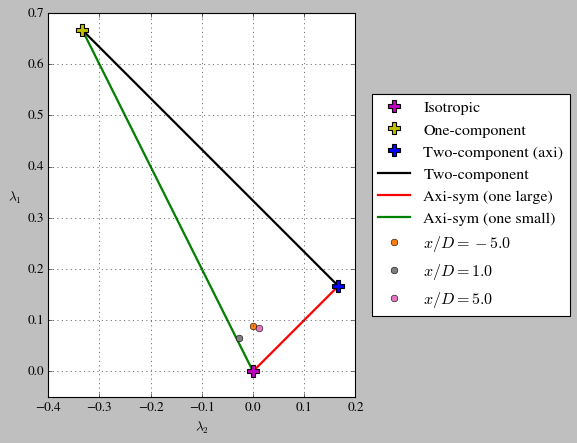

In [6]:
#### EIGENMAP - MANUALLY PLOT LIMITING CORNERS ###########
# NOTE: Lambda_1 is traditionally plooted on the y-axis (Banerjee 2007) and (Emory 2014)!
fig = plt.figure()

# Isotropic
lam1_iso = 0; lam2_iso = 0
plt.plot(lam2_iso, lam1_iso,'mP', markersize=10, mew=1, label='Isotropic', zorder=99)

# One-component
lam1_oc = 2/3; lam2_oc = -1/3;
plt.plot(lam2_oc, lam1_oc,'yP', markersize=10, mew=1, label='One-component', zorder=99)

# Two-component axi
lam1_tca = 1/6; lam2_tca = 1/6;
plt.plot(lam2_tca, lam1_tca,'bP', markersize=10, mew=1, label='Two-component (axi)', zorder=99)

# Two-component
lam2_tc = np.linspace(-1/3,1/6,50) 
lam1_tc = 1/3 - lam2_tc
plt.plot(lam2_tc, lam1_tc,'k', linewidth=2, label='Two-component')

# Axisymmetric-large
lam2_al = np.linspace(0,1/6,50) 
lam1_al = lam2_al
plt.plot(lam2_al, lam1_al,'r', linewidth=2, label='Axi-sym (one large)')

# Axisymetric-small
lam2_as = np.linspace(-1/3,0,50) 
lam1_as = -2*lam2_as
plt.plot(lam2_as, lam1_as,'g', linewidth=2, label='Axi-sym (one small)')

# Plot stuff
plt.axis('scaled')
plt.xlim(left=-0.4,right=0.2)
plt.ylim(bottom=-0.05,top=0.7)
plt.xlabel('$\lambda_2$')
plt.ylabel('$\lambda_1$',yd)



###### Stress data from the plot_stress.py script ###########

## CREATE STRESS MATRICES ######################
def create_uiuj_matrix(data, pos):
    '''
    Create the uiuj stress tensor at a position in space
    Input:
        - data: a netcdf file of the stresses
        - position: [x, y, z]  (a list of the position)
    '''
    
    uiuj = np.zeros((3,3))
    data_pos = data.interp(x=pos[0], y=pos[1], z=pos[2])
    uiuj[0,0] = data_pos['uu']
    uiuj[1,1] = data_pos['vv']
    uiuj[2,2] = data_pos['ww']
    uiuj[0,1] = data_pos['uv']
    uiuj[1,0] = data_pos['uv']
    uiuj[0,2] = data_pos['uw']
    uiuj[2,0] = data_pos['uw']
    uiuj[1,2] = data_pos['vw']
    uiuj[2,1] = data_pos['vw']
    
    return uiuj


print('----- Reynolds stress tensors extracted from the first plot of the notebook -----\n')
lam_ex_color = ['tab:orange', 'tab:grey', 'tab:pink']
lam_ex = np.zeros((len(x_ex), 3))  # Each point has three eigenvalues
for i in range(len(x_ex)):
    print('\nStress tensor at x/D=%.1f, y/D=%.1f, z=z_hub:'%(x_ex[i]/D, 0.0))
    uiuj_ex = create_uiuj_matrix(stresses, pos=[x_ex[i], 0, zh])
    print(uiuj_ex)
    k_ex = 0.5*np.trace(uiuj_ex)
    b_ex = uiuj_ex/(2*k_ex) - 1/3*np.diag(np.ones(3))
    w_ex, V_ex = np.linalg.eig(b_ex)
    lam_ex[i] = np.sort(w_ex)[::-1]   # [::-1] needed to have increasing order
    if(np.sum(lam_ex[i]) > 1e-6):
        print('Something wrong... trace should be 0!')
    print('Eigenvalues: ' + str(lam_ex[i]))
    plt.plot([lam_ex[i,1]], [lam_ex[i,0]], 'o', color=lam_ex_color[i], label='$x/D=%.1f$'%(x_ex[i]/D))


fig.legend(loc='center right',bbox_to_anchor=(1.1, 0.5))

The anistropy is in the "isotropic end" for all three points (not exactly isotropic, because there is also a $\overline{uw}$-component even in the freestream, c.f. first figure of the notebook).

## Barycentric map

Banerjee (2007) suggested a transformation of the eigenmap to the so called *barycentrip map* with coordinates ($x_B$, $y_B$):

$$
\begin{align}
 x_B &= C_{1c} + \frac{1}{2} C_{3c}  \\
 y_B &= \frac{\sqrt{3}}{2} C_{3c} ,
\end{align}
$$

where

$$
\begin{align}
 C_{1c} &=  \lambda_1 - \lambda_2  \\
 C_{3c} &= 3 (-\lambda_1 - \lambda_2) + 1  .
\end{align}
$$




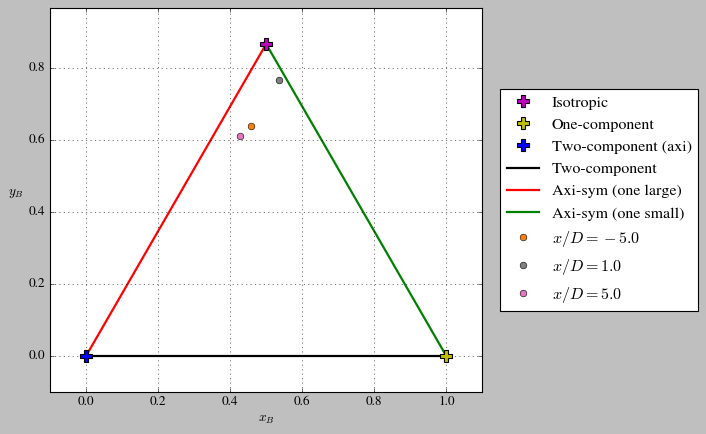

In [7]:
######## BARYCENTRIC MAP #####################
# Plot the same things as in the eigenmap above, but just in a barycentric map
fig = plt.figure()


# Isotropic
C1_iso = lam1_iso - lam2_iso
C3_iso = 3*(-lam1_iso - lam2_iso) + 1
x_iso = C1_iso + 0.5*C3_iso
y_iso = np.sqrt(3)/2*C3_iso
plt.plot(x_iso, y_iso,'mP', markersize=10, mew=1, label='Isotropic', zorder=99)

# One-component
C1_oc = lam1_oc - lam2_oc
C3_oc = 3*(-lam1_oc - lam2_oc) + 1
x_oc = C1_oc + 0.5*C3_oc
y_oc = np.sqrt(3)/2*C3_oc
plt.plot(x_oc, y_oc,'yP', markersize=10, mew=1, label='One-component', zorder=99)

# Two-component axisymetric
C1_tca = lam1_tca - lam2_tca
C3_tca = 3*(-lam1_tca - lam2_tca) + 1
x_tca = C1_tca + 0.5*C3_tca
y_tca = np.sqrt(3)/2*C3_tca
plt.plot(x_tca, y_tca,'bP', markersize=10, mew=1, label='Two-component (axi)', zorder=99)

# Two-component
C1_tc = lam1_tc - lam2_tc
C3_tc = 3*(-lam1_tc - lam2_tc) + 1
x_tc = C1_tc + 0.5*C3_tc
y_tc = np.sqrt(3)/2*C3_tc
plt.plot(x_tc, y_tc,'k', linewidth=2, label='Two-component')

# Axisymetric-large
C1_al = lam1_al - lam2_al
C3_al = 3*(-lam1_al - lam2_al) + 1
x_al = C1_al + 0.5*C3_al
y_al = np.sqrt(3)/2*C3_al
plt.plot(x_al, y_al,'r', linewidth=2, label='Axi-sym (one large)')

# Axisymetric-small
C1_as = lam1_as - lam2_as
C3_as = 3*(-lam1_as - lam2_as) + 1
x_as = C1_as + 0.5*C3_as
y_as = np.sqrt(3)/2*C3_as
plt.plot(x_as, y_as,'g', linewidth=2, label='Axi-sym (one small)')

# Plot RANS data (from first plot of the notebook) extracted at x_ex
for i in range(len(x_ex)):
    # Stress data at x/D=-5
    lam1_ex = lam_ex[i,0]; lam2 = lam_ex[i,1]
    C1_ex = lam_ex[i,0] - lam_ex[i,1]
    C3_ex = 3*(-lam_ex[i,0] - lam_ex[i,1]) + 1
    x_B_ex = C1_ex + 0.5*C3_ex
    y_B_ex = np.sqrt(3)/2*C3_ex
    plt.plot(x_B_ex, y_B_ex, 'o', color=lam_ex_color[i], label='$x/D=%.1f$'%(x_ex[i]/D))
    
# Plot stuff
plt.axis('scaled')
plt.xlim(left=-0.1,right=1.1)
plt.ylim(bottom=-0.1,top=np.sqrt(3)/2 + 0.1)
plt.xlabel('$x_B$')
plt.ylabel('$y_B$',yd)
fig.legend(loc='center right',bbox_to_anchor=(1.2, 0.5))

The eigenmap triangle transforms to an equilateral triangle! Each point inside the equilateral triangle can be associated with an RGB-color as:

$$ \begin{bmatrix} R \\ G \\ B \end{bmatrix} = \begin{bmatrix} C_{1c} \\ C_{2c} \\ C_{3c} \end{bmatrix} ,$$

where $C_{2c} = -(C_{1c} + C_{3c}) + 1$. The RGB-color for each point in the triangle is unique and is displayed in a *barycentric* manner, hence the name (see this very nice explnation; https://codeplea.com/triangular-interpolation).


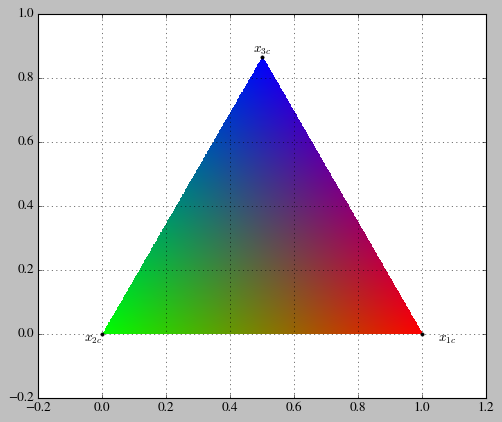

In [10]:
from mchba.flowdata import create_barytriangle

    
    
fig = plt.figure()

# Method 1: scatter 
# Disadvantage: Markersize need to be adjusted manually
# Advantage 1: Simple to implement
# Advantage 2: Can be used for unstructured data
if False:
    # Color the barycentric map using RGB triplet
    Nx = 500
    Ny = Nx
    xlin = np.linspace(0,1,Nx)
    ylin = np.linspace(0,np.sqrt(3)/2,Ny)
    X, Y = np.meshgrid(xlin,ylin)

    xB_im = X.flatten()
    yB_im = Y.flatten()
    C3_im = 2/np.sqrt(3)*yB_im
    C1_im = xB_im - 0.5*C3_im
    C2_im = -(C1_im + C3_im) + 1
    N = len(xB_im)
    rgb_im = np.zeros((N, 4)) # Default color is (0,0,0)=black, but last parameter is "opacity=0"=transparent

    for i in range(N):
        if(C1_im[i] < 0 or C2_im[i] < 0 or C3_im[i] < 0):
            # Point is outside triangle, so leave color as white
            continue
        # Point is inside triangle, use RGB color
        rgb_im[i] = np.array([C1_im[i], C2_im[i], C3_im[i], 1])
    plt.scatter(xB_im,yB_im, color=rgb_im, marker='^', s=5)

    
# Method 2: imshow
#https://stackoverflow.com/questions/44260491/matplotlib-how-to-make-imshow-read-x-y-coordinates-from-other-numpy-arrays
# Disadvantage 1: More code and not so logically
# Disadvantage 2: Can only be used for structured data with constant dx and dy
# Advantage 1: No need to adjust markersize
if True:
    # IMPORT METHOD FROM FLOWDATA LIBRARY
    create_barytriangle(plt.gca(), modmap='s')
     


Each point in space can be associated with an RGB-color, which makes it easy to visualize anisotropy in a plane. To summarize, for each point we do:

- Calculate $b_{ij}$
- Calculate eigenvalues of $b_{ij}$ and order them $\lambda_1 \geq \lambda_2 \geq \lambda_3$
- Calculate $C_{c1}$, $C_{c2}$ and $C_{c3}$; if any of these is negative, then the point is outside of the triangle, i.e. non-realizable
- Color each point according to $\mathrm{R} = C_{c1}$, $\mathrm{G} = C_{c2}$ and $\mathrm{B} = C_{c3}$

As an example, let's color the plane of first plot in this notebook:

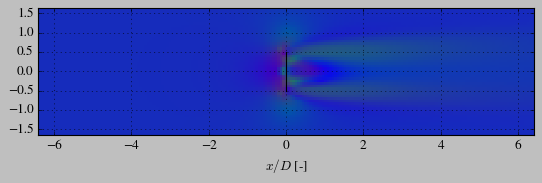

In [12]:
# Color the x-y plane of first plot in this notebook according to Emory (2014) RGB-method
from mchba.flowdata import calc_eigenvalues

stress_plane = stresses.interp(z=zh)
#print(stress_plane)

# Eigenvalues and barycentric coefficients
ev = calc_eigenvalues(stress_plane)

# Plot barycentric colored plane with imshow
dx = 8
xs = np.arange(-800,801,dx)
ys = np.arange(-200,201,dx)
extent = [(xs[0]-dx)/D, (xs[-1]+dx)/D, (ys[0]-dx)/D, (ys[-1]+dx)/D]  # Fix that imshow shows pixels
ev_g = ev.squeeze(drop='True').interp(x=xs,y=ys)  # Remove z-direction
rgb_g = np.dstack((ev_g['C1'].values.T, ev_g['C2'].values.T, ev_g['C3'].values.T))  # Stack matrices in third dim

fig = plt.figure()
plt.plot([0,0],[-0.5,0.5],'k',linewidth=1)
plt.imshow(rgb_g, origin='lower', extent=extent, interpolation='None')  # "origin=lower" = origo in lower left corner
plt.xlabel('$x/D$ [-]');


## Invariants the anisotropy tensor

Previously, we saw that the trace of any tensor (and any power of it) is invariant. Now assume the tensor is:
- Real
- Symmetric
- Traceless

For example the anisotropy tensor, $b_{ij}$!

The *principal invariants* are:

$$ I_b = \mathrm{tr}(b) = \lambda_1 + \lambda_2 + \lambda_3$$

$$ II_b = - \frac{1}{2}  \mathrm{tr}(b^2) = \lambda_1 \lambda_2 + \lambda_2 \lambda_3 +\lambda_3 \lambda_1 $$

$$ III_b =  \frac{1}{3}  \mathrm{tr}(b^3) = \lambda_1 \lambda_2 \lambda_3  $$

They are named *principal*, because they are nicely expressed by the eigenvalues. We can now utilize that the trace is always 0, i.e. $\lambda_3 = -\lambda_1 - \lambda_2$, so the invariants actually only depend on two eigenvalues:


$$ \begin{align} 
I_b &= 0
\end{align}
$$

$$ \begin{align} 
II_b &= \lambda_1 \lambda_2 + \lambda_2 (-\lambda_1 - \lambda_2) + (-\lambda_1 - \lambda_2) \lambda_1 \\
&= - \lambda_2^2 - \lambda_1^2 - \lambda_2 \lambda_1
\end{align}
$$

$$ \begin{align} 
III_b &=  \lambda_1 \lambda_2 (-\lambda_1 - \lambda_2)\\
&= - \lambda_1 \lambda_2^2 - \lambda_2 \lambda_1^2
\end{align}
$$


## Lumley triangle

Which invariants used?


## Turbulence triangle

Which invariants used?



### Intermezzo 2: Eigenvectors in 2D

A vector, which is only "stretched" by a tranformation $A$, but does **not** change direction, is called an *eigenvector*:

Mathematically speaking, for a given transformation $A$, an eigenvector satisfies:

$$ \textbf{A} \vec{v} = \lambda \vec{v} $$

Not all transformations have eigenvectors though!

Transformations with no eigenvectors in 2D:

- Rotation

Transformations with one eigenvector in 2D:

- Shear

Transformations with two eigenvectors in 2D:

- Scaling
- Reflection


For a general transformation, we can determine how many eigenvectors there are by ...



## Pope's invariants

*Since both $a_{ij}$ and $b_{ij}$ are also real and symmetric, all of the above also applies to them and will not be repeated here (only realiziability is altered).*
